In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, udf
from pyspark.sql import functions as F
from pyspark.sql.types import *
import math
from math import sqrt

In [ ]:

spark = SparkSession.builder \
    .appName("KNN_Spark") \
    .config("spark.executor.memory", "4g").config("spark.driver.memory", "4g").getOrCreate()



In [ ]:
sc = spark.sparkContext

In [ ]:
data = spark.read.option("header", True).csv("train_data.csv")
test_data = spark.read.option("header", True).csv("test_data.csv")


In [ ]:
# Function to parse the vector string dynamically
def parse_vector_string(vector_str):
    vector_str = vector_str.strip('()')
    # Split into size, indices, and values
    parts = vector_str.split(',[', 2)
    size = int(parts[0].strip('['))
    indices = list(map(int, parts[1].strip(']').split(',')))
    values = list(map(float, parts[2].strip(']').split(',')))
    full_vector = [0.0] * size
    for idx, val in zip(indices, values):
        full_vector[idx] = val
    return full_vector

# Register UDF
parse_vector_udf = udf(parse_vector_string, ArrayType(DoubleType()))



In [ ]:
def parse_vector_string_rdd(vector_str):
    vector_str = vector_str.strip('"()')
    # Split into size, indices, and values
    parts = vector_str.split(',[', 2)
    size = int(parts[0].strip('['))
    indices = list(map(int, parts[1].strip(']').split(',')))
    values = list(map(float, parts[2].strip(']').split(',')))
    full_vector = [0.0] * size
    for idx, val in zip(indices, values):
        full_vector[idx] = val
    return full_vector

In [ ]:
fileRDD = spark.sparkContext.textFile("train_data.csv")
# Skip the header and split the lines into lists of strings
dataRDD = fileRDD.filter(lambda line: 'features,LABEL' not in line).map(lambda line: (parse_vector_string_rdd(line.split('",')[0]),int(line.split('",')[1])))


In [ ]:
testRDD = spark.sparkContext.textFile("test_data.csv")
# Skip the header and split the lines into lists of strings
datatestRDD = testRDD.filter(lambda line: 'features,LABEL' not in line).map(lambda line: (parse_vector_string_rdd(line.split('",')[0]),int(line.split('",')[1])))
print(datatestRDD.take(1))

[([1.0, 1.0, 2875.0, 1031.0, 16.0, 1047.0, 1199.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
from pyspark import SparkContext, SparkConf
import numpy as np
import heapq

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def knn_distributed(train_rdd, test_rdd, k):
    train_rdd_with_id = train_rdd.zipWithIndex().map(lambda x: (x[1] % 10, x[0]))  # (partition_id, train_point)
    test_rdd_with_id = test_rdd.zipWithIndex().flatMap(
        lambda x: [(i, (x[1], x[0])) for i in range(10)]  # Broadcast các test point và các phân vùng
    )

    joined_rdd = test_rdd_with_id.join(train_rdd_with_id)  # (partition_id, (test_point, train_point))


    distances_rdd = joined_rdd.map(
        lambda x: (
            x[1][0][0],  # test_idx
            (euclidean_distance(x[1][0][1][0], x[1][1][0]), x[1][1][1]),  # (distance, train_label)
        )
    )

    neighbors_rdd = distances_rdd.groupByKey().mapValues(
        lambda neighbors: heapq.nsmallest(k, neighbors, key=lambda x: x[0])
    )

    predictions = neighbors_rdd.map(
        lambda test_idx_neighbors: (
            test_idx_neighbors[0],
            max(
                set([label for _, label in test_idx_neighbors[1]]),
                key=lambda label: [n[1] for n in test_idx_neighbors[1]].count(label),
            ),
        )
    )
    return predictions

In [ ]:
pair_rdd = datatestRDD.cartesian(dataRDD)
print(pair_rdd.take(1))

[(([8.0, 1.0, 4850.0, 2315.0, 32.0, 2347.0, 356.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
num_partitions = 10

train_data_partitions = dataRDD.repartition(num_partitions)
test_data_partitions = datatestRDD.repartition(num_partitions)

k = 5

predictions = knn_distributed(train_data_partitions, test_data_partitions, k)
predictions_mapped = predictions.map(lambda x: (x[0], x[1]))


In [ ]:
predicted_rdd = predictions

# Map test data to (test_idx, actual_label)
actual_rdd = datatestRDD.zipWithIndex().map(lambda row: (row[1], row[0][1]))  # (index, LABEL)


evaluation_rdd = predicted_rdd.join(actual_rdd)


metrics = evaluation_rdd.map(lambda x: x[1])  #(predicted_label, actual_label)

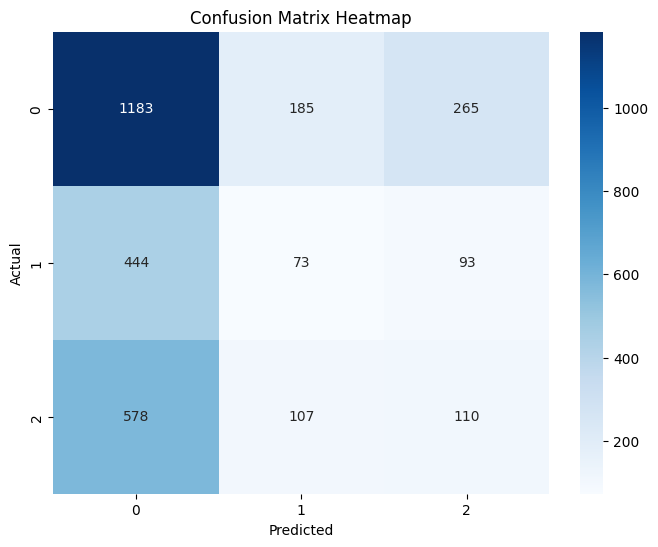

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


metrics = evaluation_rdd.map(lambda x: x[1])  #(predicted_label, actual_label)

metrics_collected = metrics.collect()

actual_labels = [x[1] for x in metrics_collected]
predicted_labels = [x[0] for x in metrics_collected]


conf_matrix = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(actual_labels), yticklabels=set(actual_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
# Accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
num_classes = conf_matrix.shape[0]
precision = []
recall = []
f1_scores = []
for i in range(num_classes):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp
    precision_i = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_i = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_i = 2 * precision_i * recall_i / (precision_i + recall_i) if (precision_i + recall_i) > 0 else 0

    precision.append(precision_i)
    recall.append(recall_i)
    f1_scores.append(f1_i)
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_scores)
# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {macro_precision:.4f}")
print(f"Recall: {macro_recall:.4f}")
print(f"F1-Score: {macro_f1:.4f}")

Accuracy: 0.4496
Precision: 0.3239
Recall: 0.3275
F1-Score: 0.3135
